In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk = subset_taxa(physeq.Bulk, Rank1=="k__Fungi")
physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS" & physeq.Bulk.m$Month %in% c("August", "November")),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq/ITS//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2247 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2247 taxa by 7 taxonomic ranks ]


In [5]:
%%R
levels(physeq.Bulk.m$Month)
sample_data(physeq.Bulk)$Month<-factor(sample_data(physeq.Bulk)$Month, levels=c("November","August"))


In [6]:
%%R
get_l2fc = function(physeq.obj, Land_Management, sparsity_threshold) {
  
    physeq.Bulk.m = physeq.obj %>% sample_data

    p = prune_samples((physeq.Bulk.m$Land_Management == Land_Management),
                           physeq.Bulk)
   
    
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Month)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}
                    
                  

In [7]:
%%R
physeq.m =  physeq.Bulk %>% sample_data 
levels(physeq.m$Month)

[1] "November" "August"  


In [8]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Land_Management) %>%
   distinct() %>%
    arrange(Land_Management) 
  

sdm

  Land_Management
1             NTH
2             NTR
3             PTH
4             PTR


In [9]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Land_Management'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 76 

  Land_Management sparsity_threshold
1             NTH               0.05
2             NTR               0.05
3             PTH               0.05
4             PTR               0.05
5             NTH               0.10
6             NTR               0.10


In [10]:
%%R
#For testing method
test = head(sdms, 5)
test

  Land_Management sparsity_threshold
1             NTH               0.05
2             NTR               0.05
3             PTH               0.05
4             PTR               0.05
5             NTH               0.10


In [11]:
%%R
physeq.Bulk.m = sample_data(physeq.Bulk)
levels(physeq.Bulk.m$Month)

[1] "November" "August"  


In [12]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [18,477 x 13]

   Land_Management sparsity_threshold       OTU log2FoldChange    lfcSE
             (chr)              (dbl)     (chr)          (dbl)    (dbl)
1              NTH               0.05 OTU.71996      2.0297666 1.755482
2              NTH               0.05  OTU.6089      2.0297666 1.755482
3              NTH               0.05 OTU.10896      2.0037123 1.741082
4              NTH               0.05 OTU.21439     -1.0114211 1.816011
5              NTH               0.05 OTU.17326     -1.6521711 1.840285
6              NTH               0.05 OTU.14908     -1.0114211 1.816011
7              NTH               0.05  OTU.6041      0.9305253 1.694794
8              NTH               0.05 OTU.38654     -1.0269793 1.851741
9              NTH               0.05  OTU.6291     -0.3660332 1.695548
10             NTH               0.05  OTU.9364     -2.1138252 1.875277
..             ...                ...       ...            ...      ...
Variables not shown: pad

In [13]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    meanl2fc
       (dbl)
1 -0.3556295


In [14]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 1.855314


In [15]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [16]:
%%R
df.l2fc$Month[df.l2fc$log2FoldChange < 0] = "November"
df.l2fc$Month[df.l2fc$log2FoldChange > 0] = "August"

In [17]:
%%R
write.table(df.l2fc, "data/l2fc_AugvsNov_all", row.names = FALSE, sep = ",")

In [18]:
%%R
df.l2fc = read.table("data/l2fc_AugvsNov_all", header = TRUE, sep = ",")

In [19]:
%%R
tail(df.l2fc)

      Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
18472             PTR               0.95   OTU.388    -1.02683537 0.6723922
18473             PTR               0.95   OTU.157    -0.29952703 0.5214870
18474             PTR               0.95    OTU.26     1.67878075 0.6557162
18475             PTR               0.95 OTU.37716     0.12128649 0.6033868
18476             PTR               0.95   OTU.102    -0.48607805 0.5892057
18477             PTR               0.95    OTU.44     0.07371995 0.7015709
            padj    Rank1           Rank2              Rank3
18472 0.34638664 k__Fungi   p__Ascomycota               <NA>
18473 0.74820601 k__Fungi   p__Ascomycota    c__unidentified
18474 0.07147978 k__Fungi p__unidentified    c__unidentified
18475 0.90706150 k__Fungi   p__Ascomycota c__Dothideomycetes
18476 0.68284499 k__Fungi   p__Ascomycota c__Sordariomycetes
18477 0.93144253 k__Fungi   p__Ascomycota c__Saccharomycetes
                     Rank4              R

In [20]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05            14
2               0.10            19
3               0.15            19
4               0.20            22
5               0.25            24
6               0.30            24


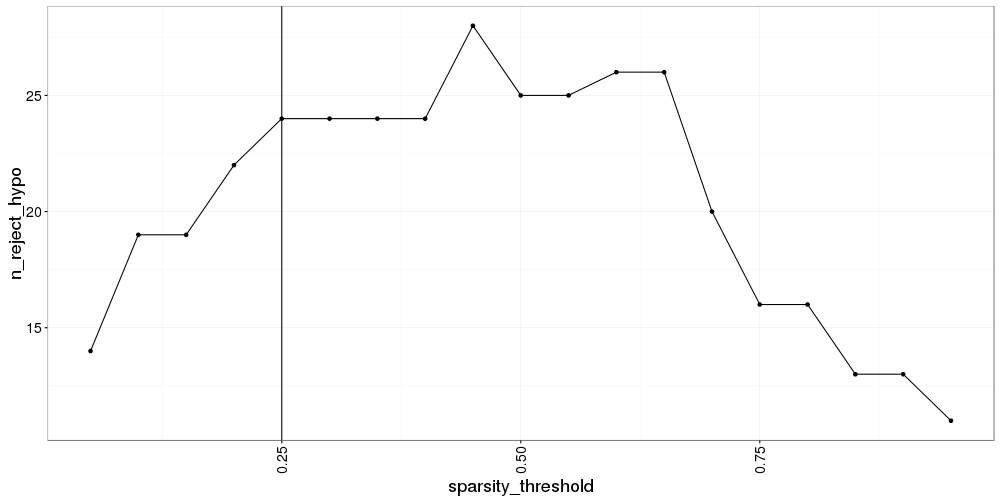

In [21]:
%%R -w 1000 -h 500

#df.l2fc.rejH.2 = filter(df.l2fc.rejH, sample.size == 15000)
ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) + geom_vline(xintercept = 0.25) +
    geom_point() +
    geom_line() +
    #facet_grid(, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))
        

In [22]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

  sparsity_threshold n_reject_hypo
1               0.05            14
2               0.10            19
3               0.15            19


In [23]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.45


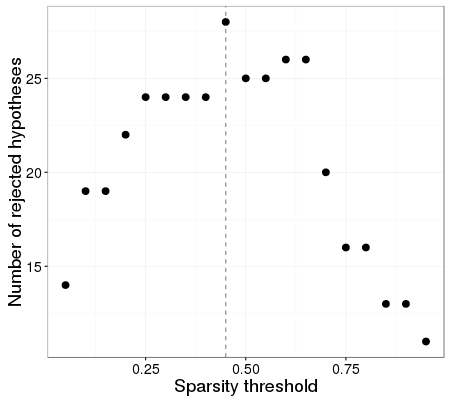

In [24]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [25]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 793


In [26]:
%%R
head(df.l2fc.f)

  Land_Management sparsity_threshold      OTU log2FoldChange     lfcSE
1             NTH               0.45 OTU.1470      1.0803916 0.9464065
2             NTH               0.45  OTU.133     -0.1839147 0.5817831
3             NTH               0.45   OTU.45      0.6203135 0.6080123
4             NTH               0.45 OTU.2583     -0.8251040 1.0399910
5             NTH               0.45 OTU.3002      0.5531737 0.9347703
6             NTH               0.45 OTU.1434     -0.5216859 0.9856805
       padj    Rank1            Rank2              Rank3          Rank4
1 0.7314887 k__Fungi p__Basidiomycota  c__Agaricomycetes  o__Agaricales
2 0.9410693 k__Fungi    p__Ascomycota c__Sordariomycetes o__Hypocreales
3 0.7848216 k__Fungi p__Basidiomycota  c__Agaricomycetes o__Polyporales
4 0.9144772 k__Fungi p__Basidiomycota  c__Agaricomycetes  o__Agaricales
5 0.9144772 k__Fungi p__Basidiomycota  c__Agaricomycetes  o__Agaricales
6 0.9197513 k__Fungi p__Basidiomycota  c__Agaricomycetes  o__Agaricales

In [27]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_AugNov.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_AugNov.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [5]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_AugNov.txt', sep='\t', header = TRUE)

In [6]:
%%R
df.l2fc$Rank2 = gsub("p__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("c__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("o__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("f__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("g__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub('s__', "", df.l2fc$Rank7)

In [7]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Month, Land_Management) %>% summarise(resp = n())
resp %>% as.data.frame

     Month Land_Management resp
1   August             PTH    4
2   August             PTR    1
3 November             NTH    1
4 November             NTR   21
5 November             PTR    1



####Function arguments

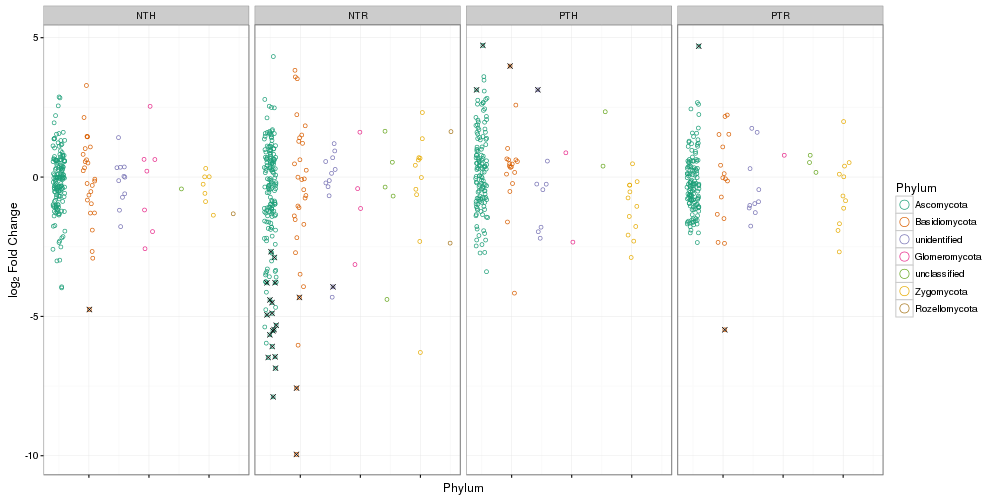

In [8]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [9]:
%%R
head(df.l2fc)

  Land_Management sparsity_threshold      OTU log2FoldChange     lfcSE
1             NTH               0.45 OTU.1470      1.0803916 0.9464065
2             NTH               0.45  OTU.133     -0.1839147 0.5817831
3             NTH               0.45   OTU.45      0.6203135 0.6080123
4             NTH               0.45 OTU.2583     -0.8251040 1.0399910
5             NTH               0.45 OTU.3002      0.5531737 0.9347703
6             NTH               0.45 OTU.1434     -0.5216859 0.9856805
       padj    Rank1         Rank2           Rank3       Rank4           Rank5
1 0.7314887 k__Fungi Basidiomycota  Agaricomycetes  Agaricales     Agaricaceae
2 0.9410693 k__Fungi    Ascomycota Sordariomycetes Hypocreales    Hypocreaceae
3 0.7848216 k__Fungi Basidiomycota  Agaricomycetes Polyporales Ganodermataceae
4 0.9144772 k__Fungi Basidiomycota  Agaricomycetes  Agaricales Psathyrellaceae
5 0.9144772 k__Fungi Basidiomycota  Agaricomycetes  Agaricales  Entolomataceae
6 0.9197513 k__Fungi Basidiom

In [10]:
%%R
test = filter(df.l2fc, padj <=0.10, log2FoldChange <0, Land_Management == "NTR") 
range(test$log2FoldChange)

[1] -9.951657 -2.309560


In [11]:
%%R
print(2^2.309560)
print(2^9.951657)

[1] 4.957319
[1] 990.2555


In [12]:
%%R
filter(test, log2FoldChange < -6.6)

  Land_Management sparsity_threshold       OTU log2FoldChange    lfcSE
1             NTR               0.45  OTU.2624      -7.572566 1.873238
2             NTR               0.45   OTU.663      -6.857684 1.254821
3             NTR               0.45   OTU.549      -9.951657 1.696883
4             NTR               0.45 OTU.64249      -7.886371 1.925807
          padj    Rank1         Rank2           Rank3               Rank4
1 8.201671e-04 k__Fungi Basidiomycota Tremellomycetes Cystofilobasidiales
2 2.637559e-06 k__Fungi    Ascomycota   Leotiomycetes          Helotiales
3 3.420255e-07 k__Fungi Basidiomycota Tremellomycetes        unidentified
4 7.400986e-04 k__Fungi    Ascomycota Dothideomycetes                <NA>
           Rank5         Rank6              Rank7        padj2    Month
1 Incertae sedis     Mrakiella Mrakiella aquatica 0.0480994394 November
2    Helotiaceae Articulospora               <NA> 0.0008276844 November
3   unidentified  unidentified Tremellomycetes sp 0.0001548

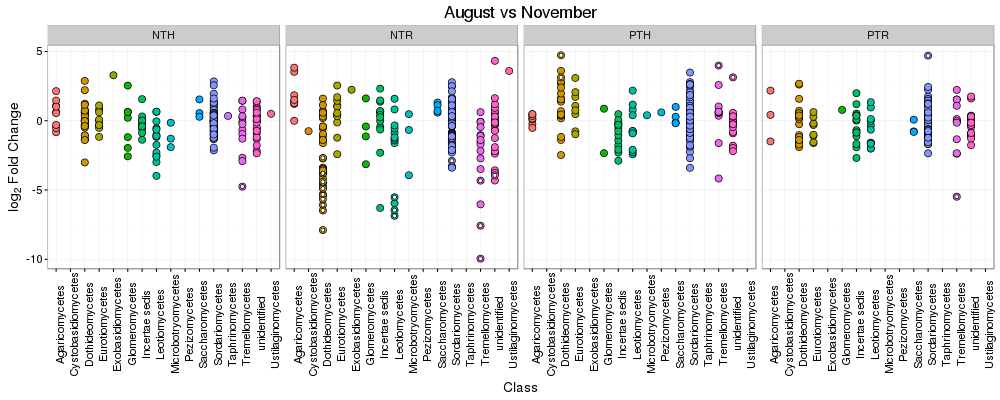

In [13]:
%%R -w 1000 -h 400
d = df.l2fc

#d = filter(d, padj2 <=0.10)
FDR = 0.10

d$Rank2 = as.character(d$Rank3)
d$Rank2[is.na(d$Rank3)] = "unclassified"
d$Rank2 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = Rank3, y = log2FoldChange, fill = Rank3))
p = p + facet_grid(~Land_Management)

p = p + geom_point(alpha = 1.00, shape = 21, size = 3)

p = p + scale_color_manual(values = getPalette(colourCount))

#p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "white", shape = 21, size = 1.5)


p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4))) +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) +
        guides(fill = FALSE)+ ggtitle("August vs November")

p


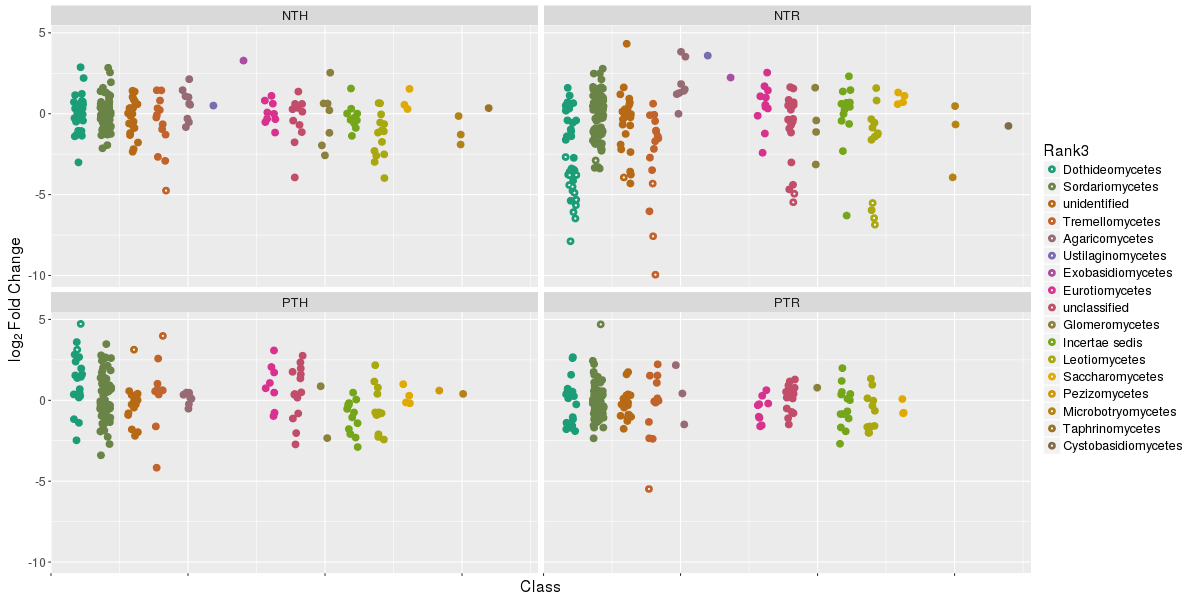

In [23]:
%%R -w 1200 -h 600
d = df.l2fc
FDR = 0.10

#d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank3= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))

p = p + geom_point(alpha = 1.00, shape = 19, size = 3)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), fill = "white", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

#p = p + theme_bw()

p = p + facet_wrap(~Land_Management)

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")


p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(fill = guide_legend(override.aes = list(size= 6), ncol = 1))  +
    theme(text = element_text(size=16)) 


p

In [25]:
%%R
ggsave(filename = "data/figs/OTUs_AugNov.png", plot = p, width =12, height =6)

In [26]:
%%R
resps = df.l2fc %>% filter(padj2<=0.10)
print(length(resps$OTU))
print(length(unique(resps$OTU)))

[1] 28
[1] 24


In [27]:
%%R
filter(df.l2fc, Land_Management == 'NTR' & padj2 <=0.10)

   Land_Management sparsity_threshold       OTU log2FoldChange     lfcSE
1              NTR               0.45  OTU.2624      -7.572566 1.8732379
2              NTR               0.45    OTU.25      -5.472073 0.8782028
3              NTR               0.45  OTU.1672      -5.317637 1.1485309
4              NTR               0.45   OTU.655      -4.504552 1.1155999
5              NTR               0.45    OTU.66      -2.677968 0.6296690
6              NTR               0.45   OTU.663      -6.857684 1.2548215
7              NTR               0.45   OTU.145      -6.079608 0.8129389
8              NTR               0.45   OTU.893      -5.516557 1.3047341
9              NTR               0.45   OTU.692      -6.449119 1.2989698
10             NTR               0.45   OTU.214      -3.795158 1.0194823
11             NTR               0.45   OTU.388      -4.945246 1.2940866
12             NTR               0.45   OTU.105      -2.885784 0.7534037
13             NTR               0.45   OTU.549    

In [28]:
%%R
soil.temp = read.table('data/l2fc_Temp.txt', sep = '\t', header = TRUE)
head(soil.temp)

  Land_Management sparsity_threshold       OTU log2FoldChange      lfcSE
1             NTH               0.15  OTU.6089    0.084353754 0.05393786
2             NTH               0.15 OTU.14908    0.101137180 0.05502467
3             NTH               0.15  OTU.6291    0.016149121 0.05103302
4             NTH               0.15  OTU.9364   -0.062835990 0.05443116
5             NTH               0.15   OTU.586    0.043196330 0.04949675
6             NTH               0.15  OTU.1470    0.004171283 0.04068918
       padj    Rank1            Rank2              Rank3           Rank4
1 0.5584573 k__Fungi  p__unidentified    c__unidentified o__unidentified
2 0.4119578 k__Fungi p__Basidiomycota  c__Agaricomycetes   o__Agaricales
3 0.9522292 k__Fungi p__Basidiomycota  c__Agaricomycetes   o__Agaricales
4 0.7365472 k__Fungi p__Basidiomycota  c__Agaricomycetes    o__Boletales
5 0.8432129 k__Fungi    p__Ascomycota c__Dothideomycetes            <NA>
6 0.9910877 k__Fungi p__Basidiomycota  c__Agaricomy

In [29]:
%%R
temp_Nov = left_join(df.l2fc, soil.temp, by = c('OTU', 'Land_Management'))

In [30]:
%%R
head(temp_Nov)

  Land_Management sparsity_threshold.x      OTU log2FoldChange.x   lfcSE.x
1             NTH                 0.45 OTU.1470        1.0803916 0.9464065
2             NTH                 0.45  OTU.133       -0.1839147 0.5817831
3             NTH                 0.45   OTU.45        0.6203135 0.6080123
4             NTH                 0.45 OTU.2583       -0.8251040 1.0399910
5             NTH                 0.45 OTU.3002        0.5531737 0.9347703
6             NTH                 0.45 OTU.1434       -0.5216859 0.9856805
     padj.x  Rank1.x       Rank2.x         Rank3.x     Rank4.x         Rank5.x
1 0.7314887 k__Fungi Basidiomycota  Agaricomycetes  Agaricales     Agaricaceae
2 0.9410693 k__Fungi    Ascomycota Sordariomycetes Hypocreales    Hypocreaceae
3 0.7848216 k__Fungi Basidiomycota  Agaricomycetes Polyporales Ganodermataceae
4 0.9144772 k__Fungi Basidiomycota  Agaricomycetes  Agaricales Psathyrellaceae
5 0.9144772 k__Fungi Basidiomycota  Agaricomycetes  Agaricales  Entolomataceae
6

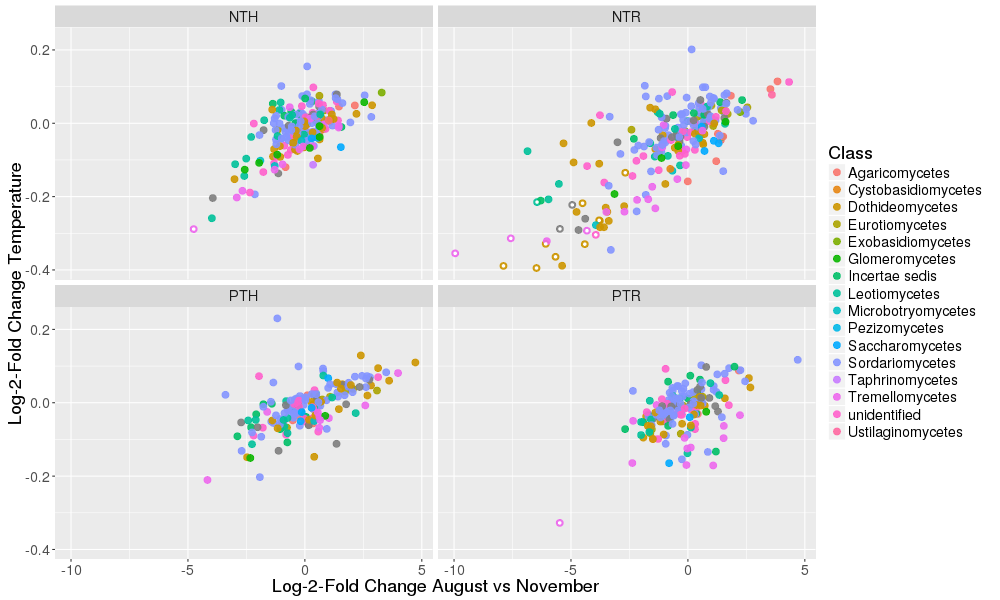

In [52]:
%%R -w 1000 -h 600
p = ggplot(temp_Nov, aes(log2FoldChange.x, log2FoldChange.y)) + geom_point(aes(color = Rank3.x), alpha = 0.9, size = 3) +
    # geom_abline(intercept = 0, slope = 1 ) + # geom_path(data=test, aes(x=x, y=y), size=1, linetype=1) +

    facet_wrap(~Land_Management) +
     theme(
        text = element_text(size=18)) + xlab('Log-2-Fold Change August vs November') + 
        ylab('Log-2-Fold Change Temperature') + geom_point(data = subset(temp_Nov, padj2.x <=0.10 & padj2.y <=0.10), 
                                                           size = 1, color = 'white') +
    scale_colour_discrete(name = 'Class')
p

In [54]:
%%R
ggsave(filename = "data/figs/OTUs_AugNov_vs_Temp.png", plot = p, width =12, height =8)

In [32]:
%%R
test = filter(temp_Nov, padj2.x <=0.10 & padj2.y <=0.10) %>% group_by(Rank3.x, Rank6.x,Land_Management) %>% summarise(n = n())

test %>% as.data.frame()

           Rank3.x       Rank6.x Land_Management n
1  Dothideomycetes Leptosphaeria             NTR 1
2  Dothideomycetes          <NA>             NTR 7
3    Leotiomycetes Hymenoscyphus             NTR 1
4  Tremellomycetes     Dioszegia             NTR 1
5  Tremellomycetes     Mrakiella             NTR 1
6  Tremellomycetes  unidentified             NTH 1
7  Tremellomycetes  unidentified             NTR 1
8  Tremellomycetes  unidentified             PTR 1
9     unidentified  unidentified             NTR 1
10            <NA>          <NA>             NTR 2


## Looking at similarity of Responders in Treatments in various month combinations

In [33]:
%%R
df.AugApril = read.table('data/l2fc_sparse-maxRejH_AugApril.txt', sep = '\t', header = TRUE)
df.AugApril = select(df.AugApril, Land_Management, OTU, log2FoldChange, padj2, Month)

df.AprilNov = read.table('data/l2fc_sparse-maxRejH_AprilvsNov.txt', sep = '\t', header = TRUE)
df.AprilNov = select(df.AprilNov, Land_Management, OTU, log2FoldChange, padj2, Month)

df.l2fc = select(df.l2fc, Land_Management, OTU, log2FoldChange, padj2, Month, Rank2, Rank3, Rank4, Rank5)


In [34]:
%%R
df.l2fc = plyr::rename(df.l2fc, c('log2FoldChange' = 'LFC_AugNov') )
df.l2fc = plyr::rename(df.l2fc, c('padj2' = 'p_AugNov') )
df.l2fc = plyr::rename(df.l2fc, c('Month' = 'Month_AugNov') )


df.AugApril = plyr::rename(df.AugApril, c('log2FoldChange' = 'LFC_AugAp') )
df.AugApril = plyr::rename(df.AugApril, c('padj2' = 'p_AugAp') )
df.AugApril = plyr::rename(df.AugApril, c('Month' = 'Month_AugAp') )


df.AprilNov = plyr::rename(df.AprilNov, c('log2FoldChange' = 'LFC_ApNov') )
df.AprilNov = plyr::rename(df.AprilNov, c('padj2' = 'p_ApNov') )
df.AprilNov = plyr::rename(df.AprilNov, c('Month' = 'Month_ApNov') )

In [35]:
%%R
print(head(df.l2fc))
print(head(df.AugApril))
print(head(df.AprilNov))

  Land_Management      OTU LFC_AugNov p_AugNov Month_AugNov         Rank2
1             NTH OTU.1470  1.0803916        1       August Basidiomycota
2             NTH  OTU.133 -0.1839147        1     November    Ascomycota
3             NTH   OTU.45  0.6203135        1       August Basidiomycota
4             NTH OTU.2583 -0.8251040        1     November Basidiomycota
5             NTH OTU.3002  0.5531737        1       August Basidiomycota
6             NTH OTU.1434 -0.5216859        1     November Basidiomycota
            Rank3       Rank4           Rank5
1  Agaricomycetes  Agaricales     Agaricaceae
2 Sordariomycetes Hypocreales    Hypocreaceae
3  Agaricomycetes Polyporales Ganodermataceae
4  Agaricomycetes  Agaricales Psathyrellaceae
5  Agaricomycetes  Agaricales  Entolomataceae
6  Agaricomycetes  Agaricales Psathyrellaceae
  Land_Management      OTU   LFC_AugAp   p_AugAp Month_AugAp
1             NTH OTU.1470 -0.05132044 0.9986251       April
2             NTH OTU.3084  0.32388945

In [36]:
%%R
print(length(df.l2fc$OTU))
print(length(df.AugApril$OTU))
print(length(df.AprilNov$OTU))

[1] 793
[1] 686
[1] 831


In [37]:
%%R
df.tot = full_join(df.l2fc, df.AugApril, by = c('OTU', 'Land_Management'))

In [38]:
%%R
df.tot2 = full_join(df.tot, df.AprilNov, by = c('OTU', 'Land_Management'))

In [39]:
%%R
write.csv(df.tot2, 'data/Month_Comparisons_byTreat.csv')

In [40]:
%%R
(df.tot2) %>% arrange(OTU) %>% head()

  Land_Management       OTU LFC_AugNov  p_AugNov Month_AugNov      Rank2
1             PTR   OTU.100 -0.1402909 1.0000000     November Ascomycota
2             NTR  OTU.1001 -4.7602133 0.2649502     November Ascomycota
3             PTH  OTU.1001  2.8298233 1.0000000       August Ascomycota
4             PTR  OTU.1001  2.6725195        NA       August Ascomycota
5             NTH  OTU.1001         NA        NA         <NA>       <NA>
6             PTR OTU.10077         NA        NA         <NA>       <NA>
            Rank3        Rank4        Rank5 LFC_AugAp   p_AugAp Month_AugAp
1    unidentified unidentified unidentified  3.932231 0.9986251      August
2 Dothideomycetes Pleosporales unidentified        NA        NA        <NA>
3 Dothideomycetes Pleosporales unidentified  6.335974 0.1155240      August
4 Dothideomycetes Pleosporales unidentified  1.271399        NA      August
5            <NA>         <NA>         <NA> -1.401868 0.9986251       April
6            <NA>         <NA>   

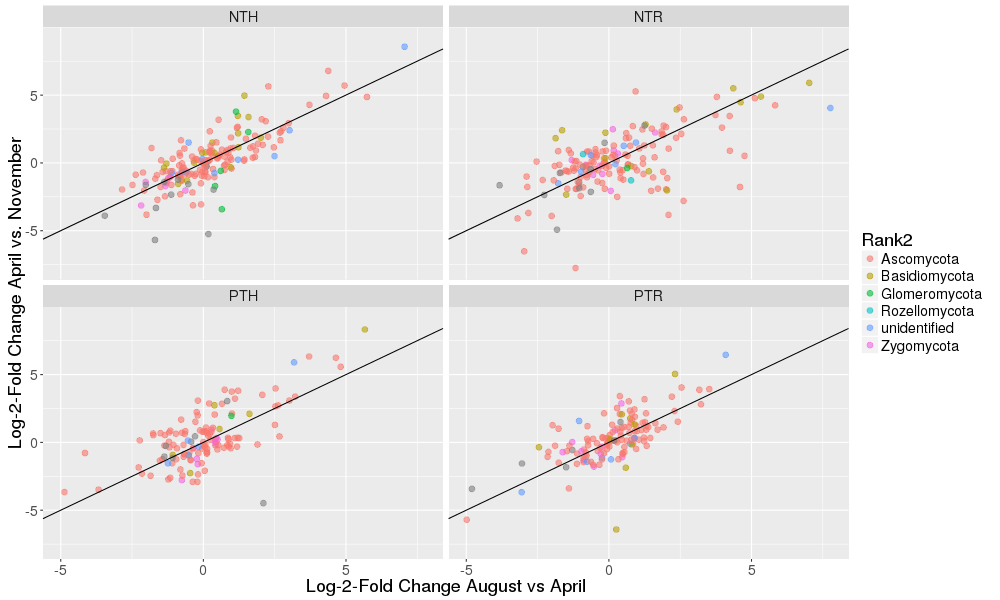

In [41]:
%%R -w 1000 -h 600
p = ggplot(df.tot2, aes(LFC_ApNov, LFC_AugAp)) + geom_point(aes(color = Rank2), alpha = 0.6, size = 2.5) +
     geom_abline(intercept = 0, slope = 1 ) + # geom_path(data=test, aes(x=x, y=y), size=1, linetype=1) +

    facet_wrap(~Land_Management) +
     theme(
        text = element_text(size=18)) + xlab('Log-2-Fold Change August vs April') + 
        ylab('Log-2-Fold Change April vs. November') 
p

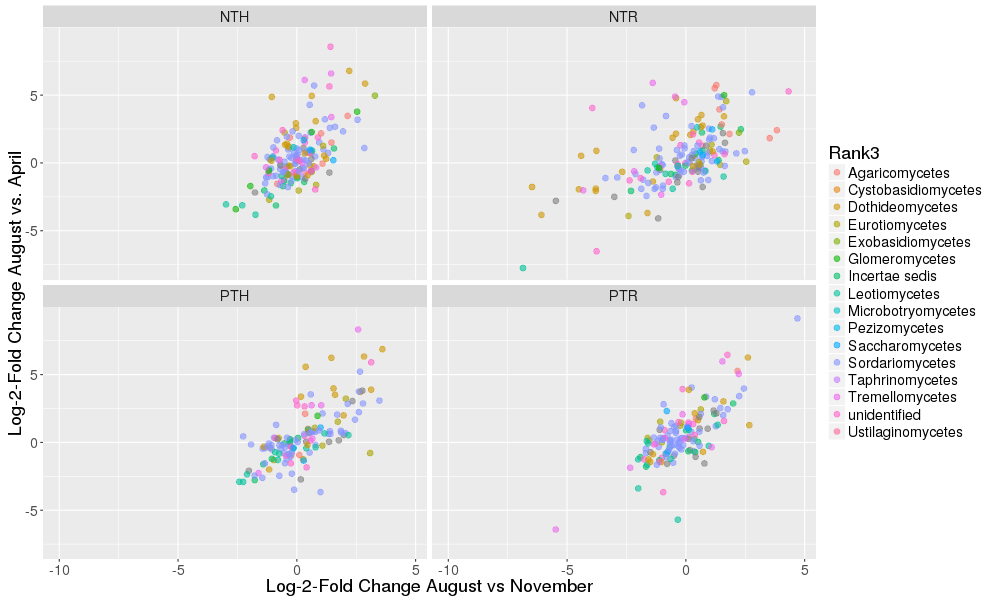

In [42]:
%%R -w 1000 -h 600
p = ggplot(df.tot2, aes(x = LFC_AugNov, y = LFC_AugAp)) + geom_point(aes(color = Rank3), alpha = 0.6, size = 2.5) +
    #geom_abline(intercept = 0, slope = 1 ) + 
    facet_wrap(~Land_Management) +
     theme(
        text = element_text(size=18)) + xlab('Log-2-Fold Change August vs November') + 
        ylab('Log-2-Fold Change August vs. April')  
p

In [43]:
%%R
df.tot2 %>% group_by(OTU) %>% filter(p_AugNov <=0.10, p_AugAp <=0.10) %>%
        summarise(resp = n()) %>% filter(resp >1)

Source: local data frame [1 x 2]

     OTU  resp
   (chr) (int)
1 OTU.26     2


In [44]:
%%R
(df.tot2) %>% group_by(OTU) %>% filter(p_AugNov <=0.10, p_ApNov<=0.10) %>%
        summarise(resp = n()) %>% filter(resp >1)

Source: local data frame [0 x 2]

Variables not shown: OTU (chr), resp (int)


In [45]:
%%R
(df.tot2) %>% group_by(OTU) %>% 
    filter(p_AugAp <=0.10, p_ApNov<=0.10) %>% summarise(resp = n()) %>% filter(resp == 1)

Source: local data frame [0 x 2]

Variables not shown: OTU (chr), resp (int)


In [46]:
%%R
filter(df.tot2, OTU %in% c('OTU.1198', 'OTU.25', 'OTU.589', 'OTU.28503', 'OTU.11966', 'OTU.30166', 'OTU.4848')) %>% 
                                                            filter(p_AugNov <=0.10 | p_AugAp <=0.10|
                                                                                    p_ApNov <=0.10) %>%
        arrange(OTU) %>% select(-LFC_AugNov, -LFC_AugAp, -LFC_ApNov)

  Land_Management    OTU     p_AugNov Month_AugNov      Rank2 Rank3 Rank4 Rank5
1             NTR OTU.25 2.953518e-05     November Ascomycota  <NA>  <NA>  <NA>
      p_AugAp Month_AugAp p_ApNov Month_ApNov
1 0.004016411       April       1    November


In [47]:
%%R
df.NT = read.table('data/l2fc_Till.txt', sep = '\t', header = TRUE)
df.OM = read.table('data/l2fc_sparse-maxRejH_bulk_OM.txt', sep = '\t', header = TRUE)
#df.tillmonth = read.table('data/l2fc_sparse-maxRejH_BULK_0.25_.txt', sep = '\t', header = TRUE)

In [48]:
%%R
filter(df.NT, OTU %in% c('OTU.1198', 'OTU.25', 'OTU.589', 'OTU.28503', 'OTU.11966', 'OTU.30166', 'OTU.4848')) %>% 
         select(OTU, Rank2, Rank3) %>% unique()

     OTU         Rank2 Rank3
1 OTU.25 p__Ascomycota  <NA>


In [49]:
%%R
filter(df.NT, OTU %in% c('OTU.1198', 'OTU.25', 'OTU.589', 'OTU.28503', 'OTU.11966', 'OTU.30166', 'OTU.4848'))

  sparsity_threshold    OTU log2FoldChange     lfcSE      padj    Rank1
1               0.05 OTU.25     -0.4419726 0.3140356 0.2334223 k__Fungi
          Rank2 Rank3 Rank4 Rank5 Rank6 Rank7     padj2 Till
1 p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA> 0.2934267    N


In [50]:
%%R
filter(df.OM, OTU %in% c('OTU.1198', 'OTU.25', 'OTU.589', 'OTU.28503', 'OTU.11966', 'OTU.30166', 'OTU.4848'))

    X sparsity_threshold    OTU log2FoldChange     lfcSE         padj    Rank1
1 159               0.05 OTU.25        1.79003 0.3111276 3.010499e-07 k__Fungi
          Rank2 Rank3 Rank4 Rank5 Rank6 Rank7        padj2       OM
1 p__Ascomycota  <NA>  <NA>  <NA>  <NA>  <NA> 3.531286e-06 Returned
